<a href="https://colab.research.google.com/github/ayuksekdag/winacademy_python_dna/blob/main/final_assignment/final_co2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment / Questions

- What is the biggest predictor of a large CO2 output per capita of a country?
- Which countries are making the biggest strides in decreasing CO2 output?
- Which non-fossil fuel energy technology will have the best price in the future?

Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors. Anyway, remember to include the explanations in your report.


Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

In [63]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.4f}".format

# Scope of sources

- source 1: https://ourworldindata.org/population-growth
  - filename:population-and-demography.csv
  - alias: pop_ann_raw

- source 2: https://ourworldindata.org/co2-emissions
  - filename: annual-co2-emissions-per-country.csv
  - alias: c02_ann_raw

- source 3: https://ourworldindata.org/co2-emissions#per-capita-co2-emissions
  - filename: co2-per-capita-marimekko.csv
  - alias: co2_cap_raw

- source 4: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?most_recent_value_desc=true
  - filename: gdp-per-capita-worldbank.csv
  - alias: gdp_cap_raw

- source 5: https://ourworldindata.org/grapher/meat-consumption-vs-gdp-per-capita
  - filename: meat-consumption-vs-gdp-per-capita.csv
  - alias: meat_cap_raw




- source x: https://ourworldindata.org/grapher/per-capita-energy-use
  - filename: gdp-per-capita-worldbank
  - alias: gdp_engy

- source x: https://ourworldindata.org/grapher/levelized-cost-of-energy
  - filename:levelized-cost-of-energy.csv
  - alias: cost_engy

- source x: https://ourworldindata.org/population-growth
  - filename:population-and-demography.csv
  - alias: pop



In [64]:
#sources
pop_ann_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/population-and-demography.csv')
c02_ann_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/annual-co2-emissions-per-country.csv')
gdp_cap_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/gdp-per-capita-worldbank.csv')
meat_cap_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/meat-consumption-vs-gdp-per-capita.csv' )

cost_engy = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/levelized-cost-of-energy.csv')


# Data preparation
Renaming columns

Data conversions
  - year column to date

Cleaning of data.
  - Goal: All datasets must have same countries and same selection of years
  - How: To achieve this I take a inner join (intersection) of all datasets on country and year of the measure.


In [65]:
# remove column or select only columns needed and put them in a new dataframe
pop_ann_prep = pop_ann_raw[['Country name','Year','Population']].copy()
c02_ann_prep = c02_ann_raw[['Entity','Year','Annual CO₂ emissions']].copy()
gdp_cap_prep = gdp_cap_raw[['Entity','Year','GDP per capita, PPP (constant 2017 international $)']].copy()
meat_cap_prep = meat_cap_raw[['Entity','Year','Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita']].copy()

In [66]:
#rename long column names with spaces and special characters
pop_ann_prep.rename(columns={'Country name': 'Country', 'Population': 'Country_population' }, inplace=True)
c02_ann_prep.rename(columns={'Entity': 'Country', 'Annual CO₂ emissions': 'Country_Annual_c02'}, inplace=True)
gdp_cap_prep.rename(columns={'Entity': 'Country','GDP per capita, PPP (constant 2017 international $)': 'Annual_gdp_per_cap'}, inplace=True)
meat_cap_prep.rename(columns={'Entity': 'Country','Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita': 'Annual_meat_per_cap'}, inplace=True)

In [67]:
c02_ann_prep.dtypes

Country                object
Year                    int64
Country_Annual_c02    float64
dtype: object

In [68]:
#change datatype year to datetime
pop_ann_prep['Year'] = pd.to_datetime(pop_ann_prep['Year'], format='%Y')
c02_ann_prep['Year'] = pd.to_datetime(c02_ann_prep['Year'], format='%Y')
gdp_cap_prep['Year'] = pd.to_datetime(gdp_cap_prep['Year'], format='%Y')

#change datatype year to datetime
pop_ann_prep['Year'] = pd.to_datetime(pop_ann_prep['Year'], format='%Y')
c02_ann_prep['Country_Annual_c02'] = c02_ann_prep['Country_Annual_c02'].astype(int)
gdp_cap_prep['Annual_gdp_per_cap'] = gdp_cap_prep['Annual_gdp_per_cap'].astype(int)



#only meat filled
meat_cap_prep = meat_cap_prep[meat_cap_prep['Annual_meat_per_cap'].notnull()].copy()
#change datatype year to datetime
meat_cap_prep['Year'] = pd.to_datetime(meat_cap_prep['Year'], format='%Y')

# c02 on world level
world_c02 = c02_ann_prep[['Year','Country_Annual_c02']][c02_ann_prep['Country']=='World'].copy()
#rename column
world_c02.rename(columns={'Country_Annual_c02': 'World_Annual_c02'}, inplace=True)

# population on world level
world_pop = pop_ann_prep[['Country','Year','Country_population']][pop_ann_prep['Country']=='World'].copy()
#rename column
world_pop.rename(columns={'Country_population': 'World_population'}, inplace=True)


list_of_exclude_countries = [
     'Land-locked developing countries (LLDC)',
     'Least developed countries', 'Less developed regions',
     'Less developed regions, excluding China',
     'Less developed regions, excluding least developed countries',
     'Low-income countries', 'Lower-middle-income countries',
     'World','High-income countries','Upper-middle-income countries'
]

#remove row where Country = World or High-income countries
pop_ann_prep = pop_ann_prep[~pop_ann_prep['Country'].isin(list_of_exclude_countries)].copy()
c02_ann_prep = c02_ann_prep[~c02_ann_prep['Country'].isin(list_of_exclude_countries)].copy()
gdp_cap_prep = gdp_cap_prep[~gdp_cap_prep['Country'].isin(list_of_exclude_countries)].copy()

# meat dataset needs cleaned before joining to avoid cartesian product
print(f' \n grootte pop_ann_prep  {pop_ann_prep.shape}')
print(f' \n grootte c02_ann_prep {c02_ann_prep.shape}')
print(f' \n grootte gdp_cap_prep {gdp_cap_prep.shape}')
print(f' \n grootte meat_cap_prep {meat_cap_prep.shape}')

 
 grootte pop_ann_prep  (17568, 3)
 
 grootte c02_ann_prep (29989, 3)
 
 grootte gdp_cap_prep (6186, 3)
 
 grootte meat_cap_prep (12360, 3)


In [69]:
# INTERSECTION (INNER JOIN) TO CREATE 1 DATASET BASED ON COUNTRY AND YEAR.
# The final result will be clean set of countries having both measures

dataset_key = ['Country','Year']

pop_ann_c02_prep = (
    pd.merge(pop_ann_prep,c02_ann_prep, how="inner", on=dataset_key, suffixes=('', '_y'))
)

pop_ann_c02_gdp_prep = (
    pd.merge(pop_ann_c02_prep ,gdp_cap_prep, how="inner", on=dataset_key, suffixes=('', '_y'))
)


pop_ann_c02_gdp_meat_prep = (
    pd.merge(pop_ann_c02_gdp_prep , meat_cap_prep , how="left", on=dataset_key, suffixes=('', '_y'))
)


print(f'final dataset struct pop_ann_c02_gdp_meat_prep \n\n{pop_ann_c02_gdp_meat_prep.dtypes}')

final dataset struct pop_ann_c02_gdp_meat_prep 

Country                        object
Year                   datetime64[ns]
Country_population              int64
Country_Annual_c02              int64
Annual_gdp_per_cap              int64
Annual_meat_per_cap           float64
dtype: object


In [70]:
# pop_ann_c02_gdp_prep[pop_ann_c02_gdp_prep['Country']=='China']
# #meat_cap_prep[meat_cap_prep['Country']=='China']
# pop_ann_c02_gdp_meat_prep[pop_ann_c02_gdp_meat_prep['Country']=='India']

In [71]:
#calculate C02 per capita

pop_ann_c02_gdp_meat_prep['Annual_c02_per_cap'] = pop_ann_c02_gdp_meat_prep['Country_Annual_c02'] / pop_ann_c02_gdp_meat_prep['Country_population']

print(f'final dataset struct pop_ann_c02_gdp_prep \n\n{pop_ann_c02_gdp_meat_prep.dtypes}')

# pop_ann_c02_gdp_meat_prep[pop_ann_c02_gdp_meat_prep['Country']=='India']

final dataset struct pop_ann_c02_gdp_prep 

Country                        object
Year                   datetime64[ns]
Country_population              int64
Country_Annual_c02              int64
Annual_gdp_per_cap              int64
Annual_meat_per_cap           float64
Annual_c02_per_cap            float64
dtype: object


### Question / Assumption /Answer 1:
- Question: What is the biggest predictor of a large CO2 output per capita of a country?
- Assumption: 1.There is a strong correlation between GDP and Co2 emmission. In general higher GDP per capita means more consumption and use of energy that results in more c02 emmision
- 2. as 2nd measure I;ve taking meat consumption per capita which should also strong corrolate with GDP and eventually C02 emission

- Answer: Yes the correlation is correct. The biggest predictor of large C02 is GDP per Capita


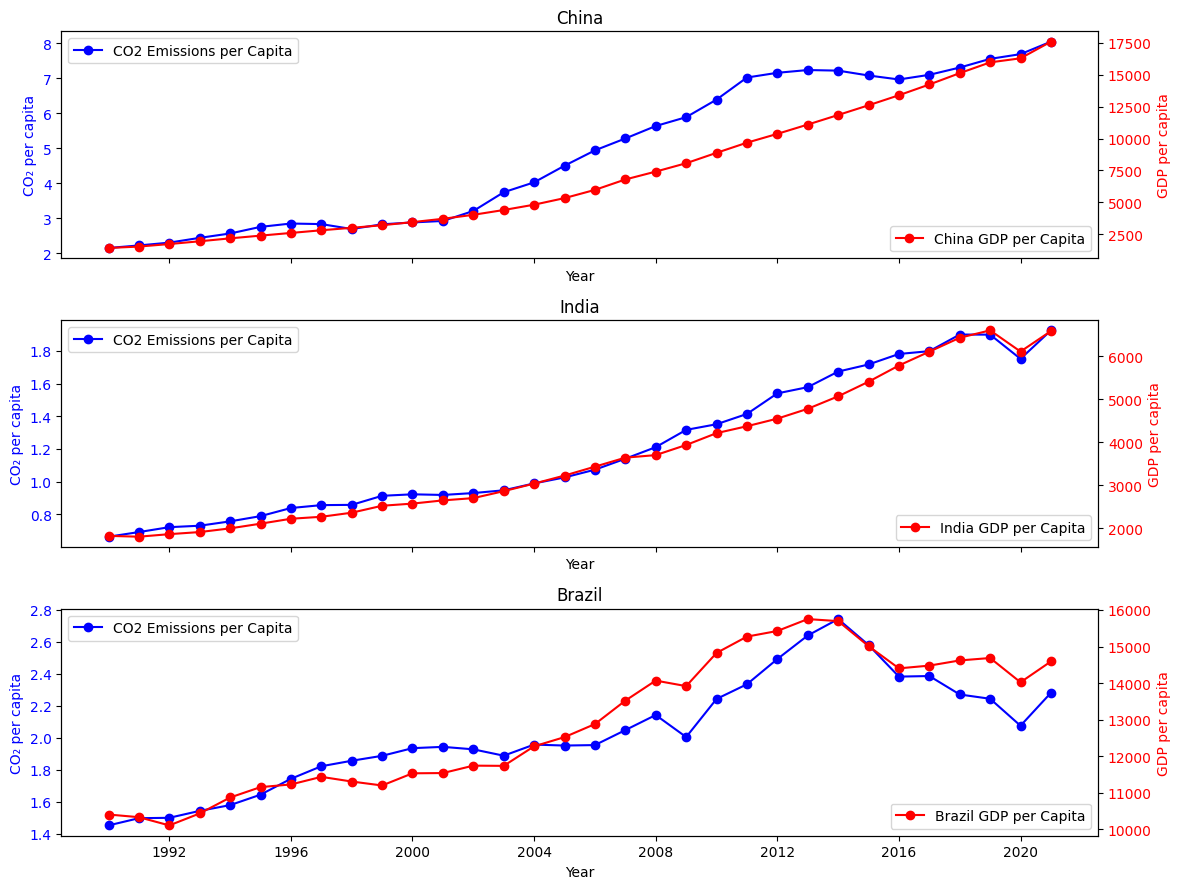

In [72]:
# We take 3 countries with large population
# 3 Bricks: China & India and Brazil
countries_to_plot = {"China", "India", "Brazil"}

# Create subplots
fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(12, 9), sharex=True)

c02_color='blue'
gdp_color='red'
pop_color='green'

#loop for every county
for i, country in enumerate(countries_to_plot):

  df = pop_ann_c02_gdp_meat_prep[pop_ann_c02_gdp_meat_prep["Country"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["Annual_c02_per_cap"], label="CO2 Emissions per Capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color=c02_color)
  ax[i].tick_params(axis='y', labelcolor=c02_color)
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure gdp on the right side
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["Annual_gdp_per_cap"], label=f"{country} GDP per Capita", marker='o', color=gdp_color)
  ax2.set_ylabel('GDP per capita', color=gdp_color)
  ax2.tick_params(axis='y', labelcolor=gdp_color)
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()



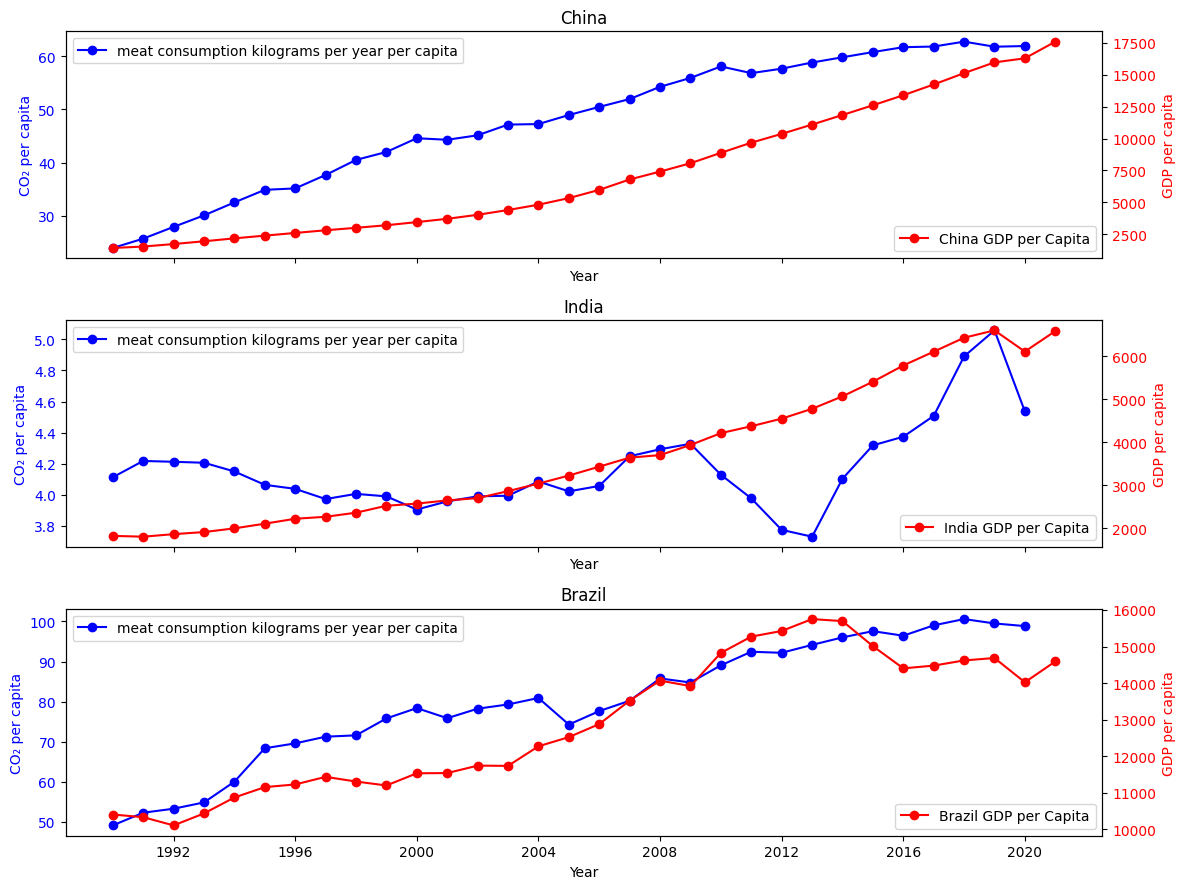

In [73]:
# We take 3 countries with large population
# 3 Bricks: China & India and Brazil
countries_to_plot = {"China", "India", "Brazil"}

# Create subplots
fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(12, 9), sharex=True)

c02_color='blue'
gdp_color='red'
pop_color='green'

#loop for every county
for i, country in enumerate(countries_to_plot):

  df = pop_ann_c02_gdp_meat_prep[pop_ann_c02_gdp_meat_prep["Country"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["Annual_meat_per_cap"], label="meat consumption kilograms per year per capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color=c02_color)
  ax[i].tick_params(axis='y', labelcolor=c02_color)
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure gdp on the right side
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["Annual_gdp_per_cap"], label=f"{country} GDP per Capita", marker='o', color=gdp_color)
  ax2.set_ylabel('GDP per capita', color=gdp_color)
  ax2.tick_params(axis='y', labelcolor=gdp_color)
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()

### Question / Answer 2:
- Question : Which countries are making the biggest strides in decreasing CO2 output?
- Assumption:
  - 1 step: We calculate the absolute performance and relative performance

  absolute c02 perc:
          country c02 / world c02 on year level
  relative c02 perc:
          country co2 / country population on year level
  
For both we take the differnce between current vs max-min value(range) during the years. The highest difference in postive direction are the biggest strides in reducing c02

The top 10 is listed in a stacked bar chart

In [84]:
c02_reduction_champs_prep = pop_ann_c02_gdp_meat_prep[['Country','Year','Country_population','Country_Annual_c02']].copy()



c02_reduction_champs_prep['lead_population'] = (c02_reduction_champs_prep.sort_values(by=['Year'], ascending=True)
.groupby(['Country'])['Country_population'].shift(-1))



c02_reduction_champs_prep['lead_c02'] = (c02_reduction_champs_prep.sort_values(by=['Year'], ascending=True)
.groupby(['Country'])['Country_Annual_c02'].shift(-1))

c02_reduction_champs_prep['lead_population'] = c02_reduction_champs_prep['lead_population'].fillna(0).astype(int)

c02_reduction_champs_prep['lead_c02'] = c02_reduction_champs_prep['lead_c02'].fillna(0).astype(int)

c02_reduction_champs_prep.dtypes

# Country                        object
# Year                   datetime64[ns]
# Country_population              int64
# Country_Annual_c02            float64
# Annual_gdp_per_cap            float64
# Annual_meat_per_cap           float64
# Annual_c02_per_cap            float64


# c02_champx['lead_c02_next_year'] = (c02_champs.sort_values(by=['Year'], ascending=True)
# .groupby(['Country'])['relative_c02_country_vs_world_perc'].shift(-1))



# c02_champs_world_c02 = (
#     pd.merge(c02_reduction_champs_prep , world_c02 , how="left", on=['Year'], suffixes=('', '_y'))
#     .filter(regex="^(?!.*_y)")
# )




# c02_champs = (
#     pd.merge(c02_champs_world_c02 , world_pop , how="left", on=['Year'], suffixes=('', '_y'))
#     .filter(regex="^(?!.*_y)")
# )

# #calculate relative_c02_percentage
# c02_champs['relative_c02_country_vs_world_perc'] = (c02_champs['Country_Annual_c02'] / c02_champs['World_Annual_c02'])


# #calculate relative_c02_percentage
# c02_champs['relative_pop_country_vs_world_perc'] = (c02_champs['Country_population'] / c02_champs['World_population'])

#highest difference


# c02_champx = c02_champs[['Country','Year','relative_c02_country_vs_world_perc','relative_pop_country_vs_world_perc']].copy()

# c02_champx['lead_c02_next_year'] = (c02_champs.sort_values(by=['Year'], ascending=True)
# .groupby(['Country'])['relative_c02_country_vs_world_perc'].shift(-1))

# c02_champx['lead_pop_next_year'] = (c02_champs.sort_values(by=['Year'], ascending=True)
# .groupby(['Country'])['relative_pop_country_vs_world_perc'].shift(-1))


# c02_champx['progress_c02'] = (c02_champx['relative_c02_country_vs_world_perc'] - c02_champx['lead_c02_next_year'])

# c02_champx['progress_pop'] = (c02_champx['relative_pop_country_vs_world_perc'] - c02_champx['lead_pop_next_year'])


# (c02_champx
# .groupby(['Country'])['progress_c02','progress_pop'].sum()
# .sort_values(by=['progress_c02','progress_pop'], ascending=True)
# )

# c02_champs[c02_champs['Country']=='China']


,Country,Year,Country_population,Country_Annual_c02,lead_population,lead_c02
0,Afghanistan,2002-01-01,21000258,1340995,22645136,1559602
1,Afghanistan,2003-01-01,22645136,1559602,23553554,1237247
2,Afghanistan,2004-01-01,23553554,1237247,24411196,1889507
3,Afghanistan,2005-01-01,24411196,1889507,25442946,2159318
4,Afghanistan,2006-01-01,25442946,2159318,25903306,2799909
...,...,...,...,...,...,...
5815,Zimbabwe,2017-01-01,14751101,9596071,15052191,11795478
5816,Zimbabwe,2018-01-01,15052191,11795478,15354606,11114607
5817,Zimbabwe,2019-01-01,15354606,11114607,15669663,10607897
5818,Zimbabwe,2020-01-01,15669663,10607897,15993525,11296114


### Question / Answer 3:
- Q: Which non-fossil fuel energy technology will have the best price in the future?
- A: take the all on rows on World level. Plot it using x-axis Year
Onshore seems to be lowest and going lower. Solar is following up.